# ***Project Time Series Audio Dataset With MultiLabel***

In [96]:
import os
import pandas as pd
import librosa
import warnings

import tsfel
from tqdm import tqdm

import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import train_test_split
from sklearn.base import clone
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import soundfile as sf

import joblib

## **Membaca Dataset**

In [10]:
# -- Mengabaikan peringatan dari librosa terkait format non-wav --
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

# Konfigurasi Path dan Label 
dataset_path = 'dataset/dataset_wav'
csv_path = 'dataset/metadata_anda.csv'


In [6]:
def load_audio_from_csv(csv_path, audio_folder_path, target_sr=16000):
    """
    Membaca dataset audio berdasarkan metadata dari file CSV.
    CSV harus memiliki kolom 'file_name' dan kolom label biner 
    (misal: 'buka', 'tutup', 'fikri', 'fauzan').
    """
    
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ File CSV '{csv_path}' tidak ditemukan.")
    if not os.path.exists(audio_folder_path):
        raise FileNotFoundError(f"❌ Folder audio '{audio_folder_path}' tidak ditemukan.")

    print(f"🚀 Membaca metadata dari: {csv_path}")
    try:
        metadata_df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"❌ Gagal membaca CSV: {e}")
        return []

    print(f"🎧 Memulai proses pembacaan file audio dari: {audio_folder_path}...")
    data_list = []

    # Loop melalui setiap baris di DataFrame CSV
    for index, row in metadata_df.iterrows():
        filename = row['file_name']
        file_path = os.path.join(audio_folder_path, filename)

        if not os.path.exists(file_path):
            print(f"  ⚠️  File '{filename}' (tercatat di CSV) tidak ditemukan di folder audio. Dilewati.")
            continue

        try:
            # Load audio, pastikan SR seragam (PENTING) dan mono
            audio_signal, sr = librosa.load(file_path, sr=target_sr, mono=True)

            # Simpan semua data, termasuk label biner
            # Kita akan olah ini nanti setelah ekstraksi fitur
            data_list.append({
                'filename': filename,
                'audio_signal': audio_signal,
                'sampling_rate': sr,
                'label_buka': int(row['buka']),
                'label_tutup': int(row['tutup']),
                'label_fikri': int(row['fikri']),
                'label_fauzan': int(row['fauzan'])
            })

        except Exception as e:
            print(f"  ❌  Error membaca file '{filename}': {e}")

    print("\n✅ Proses pembacaan data selesai.")
    print(f"📊 Total file berhasil dibaca: {len(data_list)} dari {len(metadata_df)} baris CSV.")
    
    if len(data_list) == 0:
        print("⚠️ Tidak ada data yang berhasil dimuat. Periksa kembali nama file di CSV dan di folder audio.")

    return data_list

# --- CONTOH CARA MENGGUNAKAN FUNGSI INI ---
# 1. Tentukan path Anda
# csv_file = 'dataset_baru.csv' 
# audio_folder = 'dataset_wav'

# 2. Panggil fungsi
# data_audio_baru = load_audio_from_csv(csv_file, audio_folder, target_sr=16000)

# 3. Cek hasilnya
# print(f"Contoh data pertama: {data_audio_baru[0]}")

## **Ekstraksi Fitur**

In [14]:
def extract_features_tsfel(data_list):
    """
    Mengekstraksi fitur dari setiap sinyal audio menggunakan TSFEL.
    data_list: list hasil dari load_audio_from_csv() (versi baru)
    return: DataFrame berisi fitur + semua label biner
    """
    # 1️⃣ Ambil konfigurasi default TSFEL
    cfg = tsfel.get_features_by_domain()

    feature_dfs = []  # Menyimpan hasil ekstraksi per file

    print("🚀 Memulai proses ekstraksi fitur menggunakan TSFEL...\n")

    for i, data in enumerate(data_list, 1):
        signal = data['audio_signal']
        sr = data['sampling_rate']

        try:
            # 2️⃣ Ekstraksi fitur untuk satu sinyal
            features = tsfel.time_series_features_extractor(cfg, signal, fs=sr, verbose=0)

            # 3️⃣ === PERUBAHAN DI SINI ===
            # Tambahkan metadata dan SEMUA label biner dari data_list
            features['filename'] = data['filename']
            features['label_buka'] = data['label_buka']
            features['label_tutup'] = data['label_tutup']
            features['label_fikri'] = data['label_fikri']
            features['label_fauzan'] = data['label_fauzan']
            # ==========================

            feature_dfs.append(features)

            # Hapus print agar tidak terlalu ramai (opsional)
            # print(f"✅ [{i}/{len(data_list)}] Fitur diekstrak untuk file: {data['filename']}")

        except Exception as e:
            # Tampilkan error yang lebih spesifik jika terjadi
            print(f"❌ Error saat ekstraksi fitur {data.get('filename', 'UNKNOWN')}: {e}")
            print(f"   Panjang sinyal: {len(signal)}, SR: {sr}")

    if not feature_dfs:
        print("⚠️ Tidak ada fitur yang berhasil diekstrak. Proses dihentikan.")
        return pd.DataFrame()
        
    # 4️⃣ Gabungkan semua hasil fitur menjadi satu DataFrame besar
    feature_df = pd.concat(feature_dfs, ignore_index=True)

    print("\n🎉 Ekstraksi fitur selesai!")
    print(f"📊 Total data fitur: {feature_df.shape[0]} baris, {feature_df.shape[1]} kolom")

    return feature_df

In [15]:
if __name__ == "__main__":
    # Jalankan kode membaca dataset
    dataset = load_audio_from_csv(csv_path, dataset_path, target_sr=16000)
    features_df = extract_features_tsfel(dataset)

🚀 Membaca metadata dari: dataset/metadata_anda.csv
🎧 Memulai proses pembacaan file audio dari: dataset/dataset_wav...

✅ Proses pembacaan data selesai.
📊 Total file berhasil dibaca: 400 dari 400 baris CSV.
🚀 Memulai proses ekstraksi fitur menggunakan TSFEL...


🎉 Ekstraksi fitur selesai!
📊 Total data fitur: 400 baris, 161 kolom


In [19]:
display(features_df)

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Wavelet variance_500.0Hz,0_Wavelet variance_571.43Hz,0_Wavelet variance_666.67Hz,0_Wavelet variance_800.0Hz,0_Zero crossing rate,filename,label_buka,label_tutup,label_fikri,label_fauzan
0,199.916886,0.083649,9.0,55.781354,1.834369,11468.0,45875.0,-0.002777,0.001709,0.000017,...,0.042812,0.031659,0.020734,0.011845,9625.0,voice-recorder-2025-11-02--13-08-14.wav,1,0,1,0
1,1362.971628,0.236500,9.0,354.946305,1.213369,12288.0,49152.0,-0.009888,0.005280,0.000016,...,0.286443,0.213464,0.139822,0.079558,5721.0,voice-recorder-2025-11-02--13-08-24.wav,1,0,1,0
2,866.602132,0.211150,11.0,225.681312,0.978502,12288.0,49152.0,-0.034424,0.016479,0.000016,...,0.144419,0.104278,0.065776,0.035207,5820.0,voice-recorder-2025-11-02--13-08-30.wav,1,0,1,0
3,1146.513636,0.195138,10.0,407.151663,0.775227,9011.0,36044.0,-0.016052,0.007629,0.000022,...,0.308509,0.218079,0.134105,0.069515,4266.0,voice-recorder-2025-11-02--13-08-36.wav,1,0,1,0
4,728.751226,0.170527,10.0,194.094277,0.848770,12015.0,48060.0,-0.019287,0.009216,0.000017,...,0.157957,0.114189,0.072037,0.038522,5482.0,voice-recorder-2025-11-02--13-08-43.wav,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,48.708238,0.034236,11.0,32.778087,0.910325,4755.0,19021.0,-0.011627,0.003479,0.000042,...,0.021085,0.014759,0.009092,0.004755,3143.0,tutup51.wav,0,1,0,1
396,30.968305,0.032147,11.0,15.691078,1.212779,6315.0,25263.0,-0.012054,0.004761,0.000032,...,0.007665,0.005636,0.003765,0.002213,4508.0,tutup60.wav,0,1,0,1
397,192.899147,0.069760,10.0,143.239725,0.819033,4309.0,17238.0,-0.031921,0.011139,0.000046,...,0.111300,0.078908,0.049298,0.026483,3100.0,tutup70.wav,0,1,0,1
398,1012.776862,0.197376,8.0,581.575200,1.089950,5572.0,22291.0,-0.091156,0.051941,0.000036,...,0.574797,0.443706,0.296495,0.166380,2548.0,tutup80.wav,0,1,0,1


## **Seleksi Fitur Menggunakan Penilaian Score dari Information Gain**

### *Memecah Dataset Feature Menjadi 3 Label Aksi, Label Identitas, Data Fitur*

In [20]:
print("1. Memisahkan X (fitur mentah) dan y (target)...")
label_cols = ['label_buka', 'label_tutup', 'label_fikri', 'label_fauzan', 'filename']

# X_raw berisi SEMUA fitur numerik (misal: 156 kolom)
X_raw = features_df.drop(columns=label_cols, errors='ignore') \
                   .select_dtypes(include=[np.number])

# y_aksi berisi 1 (Buka) atau 0 (Tutup)
y_aksi = features_df['label_buka'].rename("Aksi (Buka/Tutup)")

# y_identitas berisi 1 (Fikri) atau 0 (Fauzan)
y_identitas = features_df['label_fikri'].rename("Identitas (Fikri/Fauzan)")

print(f"   Bentuk X_raw: {X_raw.shape}")
print(f"   Bentuk y_aksi: {y_aksi.shape}")
print(f"   Bentuk y_identitas: {y_identitas.shape}")


1. Memisahkan X (fitur mentah) dan y (target)...
   Bentuk X_raw: (400, 156)
   Bentuk y_aksi: (400,)
   Bentuk y_identitas: (400,)


In [50]:
def bersihkan_outliers_isolation_forest(
    X_mentah, 
    y_aksi_mentah, 
    y_identitas_mentah, 
    contamination_rate=0.02
):
    """
    Fungsi lengkap untuk mengimputasi (mengisi NaN) dan membersihkan 
    outliers dari dataset (X dan y) menggunakan Isolation Forest.
    
    Args:
        X_mentah (DataFrame): DataFrame fitur mentah (misal: 156 kolom).
        y_aksi_mentah (Series): Target Series Aksi.
        y_identitas_mentah (Series): Target Series Identitas.
        contamination_rate (float): Perkiraan persentase outlier (misal: 0.02 = 2%).
        
    Returns:
        X_clean (DataFrame): Versi bersih dari X.
        y_aksi_clean (Series): Versi bersih dari y_aksi.
        y_identitas_clean (Series): Versi bersih dari y_identitas.
    """
    
    print("\n🚀 Memulai Alur Pembersihan Outlier...")

    # ==========================================================
    # 1. IMPUTASI (WAJIB SEBELUM DETEKSI OUTLIER)
    # ==========================================================
    print("1. Melakukan imputasi (median) pada X_mentah...")
    imputer = SimpleImputer(strategy='median')
    
    X_imputed_data = imputer.fit_transform(X_mentah)
    
    # Buat kembali menjadi DataFrame, JAGA INDEKS ASLI-nya
    X_imputed_df = pd.DataFrame(
        X_imputed_data, 
        columns=X_mentah.columns, 
        index=X_mentah.index
    )
    print("Imputasi selesai.")

    # ==========================================================
    # 2. DETEKSI OUTLIERS (ISOLATION FOREST)
    # ==========================================================
    print(f"2. Mendeteksi outliers (kontaminasi={contamination_rate*100}%)")
    
    iso_forest = IsolationForest(
        contamination=contamination_rate, 
        random_state=42, 
        n_jobs=-1
    )
    
    predictions = iso_forest.fit_predict(X_imputed_df)
    
    # 1 = 'inlier' (data normal), -1 = 'outlier' (data aneh)
    is_inlier_mask = (predictions == 1)
    n_outliers = (predictions == -1).sum()

    print(f"Deteksi selesai. Ditemukan {n_outliers} outliers (dari {len(X_imputed_df)} data).")

    # ==========================================================
    # 3. MEMBUAT DATASET 'BERSIH'
    # ==========================================================
    print("3. Memfilter X dan y untuk membuat dataset 'clean'...")

    X_clean = X_imputed_df[is_inlier_mask]
    y_aksi_clean = y_aksi_mentah[is_inlier_mask]
    y_identitas_clean = y_identitas_mentah[is_inlier_mask]

    print("\n--- HASIL PEMBERSIHAN ---")
    print(f"Bentuk X_clean:   {X_clean.shape} (dari {X_mentah.shape[0]} baris)")
    print(f"Bentuk y_aksi_clean: {y_aksi_clean.shape}")
    print(f"Bentuk y_identitas_clean: {y_identitas_clean.shape}")
    
    print("\n✅ Pembersihan Outlier Selesai.")
    
    return X_clean, y_aksi_clean, y_identitas_clean

In [51]:
X_clean, y_aksi_clean, y_identitas_clean = bersihkan_outliers_isolation_forest(
    X_raw, 
    y_aksi, 
    y_identitas, 
    contamination_rate=0.02 # Coba 2% dulu
)

# Cek hasil
print("\nVariabel bersih siap digunakan:")
print(X_clean.head())


🚀 Memulai Alur Pembersihan Outlier...
1. Melakukan imputasi (median) pada X_mentah...
Imputasi selesai.
2. Mendeteksi outliers (kontaminasi=2.0%)
Deteksi selesai. Ditemukan 8 outliers (dari 400 data).
3. Memfilter X dan y untuk membuat dataset 'clean'...

--- HASIL PEMBERSIHAN ---
Bentuk X_clean:   (392, 156) (dari 400 baris)
Bentuk y_aksi_clean: (392,)
Bentuk y_identitas_clean: (392,)

✅ Pembersihan Outlier Selesai.

Variabel bersih siap digunakan:
   0_Absolute energy  0_Area under the curve  0_Autocorrelation  \
0         199.916886                0.083649                9.0   
1        1362.971628                0.236500                9.0   
2         866.602132                0.211150               11.0   
3        1146.513636                0.195138               10.0   
4         728.751226                0.170527               10.0   

   0_Average power  0_Centroid  0_ECDF Percentile Count_0  \
0        55.781354    1.834369                    11468.0   
1       354.946305  

In [32]:
def hitung_skor_ig_spesialis(X_numeric, y_target_aksi, y_target_identitas):
    
    """
    Fungsi ini menerima data X dan y yang sudah dipisah, lalu menghitung
    Information Gain (IG) secara terpisah untuk kedua target.
    
    Args:
        X_numeric (DataFrame): DataFrame fitur mentah (misal: 156 kolom).
        y_target_aksi (Series): Series target untuk Aksi (Buka/Tutup).
        y_target_identitas (Series): Series target untuk Identitas (Fikri/Fauzan).
                                 
    Returns:
        ig_df (DataFrame): DataFrame berisi skor IG untuk setiap fitur
                           terhadap kedua target.
    """
    
    print("\n🚀 Memulai perhitungan Information Gain...")

    # 1️⃣ Tangani Missing Values (NaN)
    # (Penting untuk mutual_info_classif)
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X_numeric)
    X_imputed_df = pd.DataFrame(X_imputed, columns=X_numeric.columns)

    # 2️⃣ Hitung Information Gain (Mutual Information)
    print(f"Menghitung IG untuk {y_target_aksi.name}...")
    ig_aksi = mutual_info_classif(X_imputed_df, y_target_aksi, discrete_features='auto', random_state=42)
    
    print(f"Menghitung IG untuk {y_target_identitas.name}...")
    ig_identitas = mutual_info_classif(X_imputed_df, y_target_identitas, discrete_features='auto', random_state=42)

    # 3️⃣ Gabungkan hasil ke DataFrame
    ig_df = pd.DataFrame({
        "Feature": X_numeric.columns,
        "IG_Aksi": ig_aksi,
        "IG_Identitas": ig_identitas
    })

    print("✅ Perhitungan IG Selesai.")
    
# 4️⃣ Visualisasi (diubah menjadi horizontal)
    # Buat figure lebih tinggi untuk menampung 30 label di setiap plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20)) # (Tinggi ditambah)
    
    # --- ** Plot untuk IG Aksi ** ---
    # Ambil top 30, lalu reverse (iloc[::-1]) agar bar tertinggi di paling atas
    ig_df_aksi = ig_df.sort_values(by="IG_Aksi", ascending=False).head(50).iloc[::-1]
    
    # Gunakan barh (bar horizontal)
    ax1.barh(ig_df_aksi["Feature"], ig_df_aksi["IG_Aksi"], color='blue') 
    ax1.set_title(f"Top 50 Fitur Terbaik untuk [{y_target_aksi.name}]")
    ax1.set_xlabel("Skor IG") # (diubah dari set_ylabel)
    ax1.set_ylabel("Fitur")   # (diubah dari set_xlabel)
    
    # --- ** Plot untuk IG Identitas ** ---
    # Ambil top 30, lalu reverse (iloc[::-1])
    ig_df_identitas = ig_df.sort_values(by="IG_Identitas", ascending=False).head(50).iloc[::-1]
    
    # Gunakan barh (bar horizontal)
    ax2.barh(ig_df_identitas["Feature"], ig_df_identitas["IG_Identitas"], color='green')
    ax2.set_title(f"Top 50 Fitur Terbaik untuk [{y_target_identitas.name}]")
    ax2.set_xlabel("Skor IG") # (diubah dari set_ylabel)
    ax2.set_ylabel("Fitur")   # (diubah dari set_xlabel)
    
    plt.tight_layout()
    plt.show()

    return ig_df

### *Visualisasi Score Fitur Information Gain*


🚀 Memulai perhitungan Information Gain...
Menghitung IG untuk Aksi (Buka/Tutup)...
Menghitung IG untuk Identitas (Fikri/Fauzan)...
✅ Perhitungan IG Selesai.


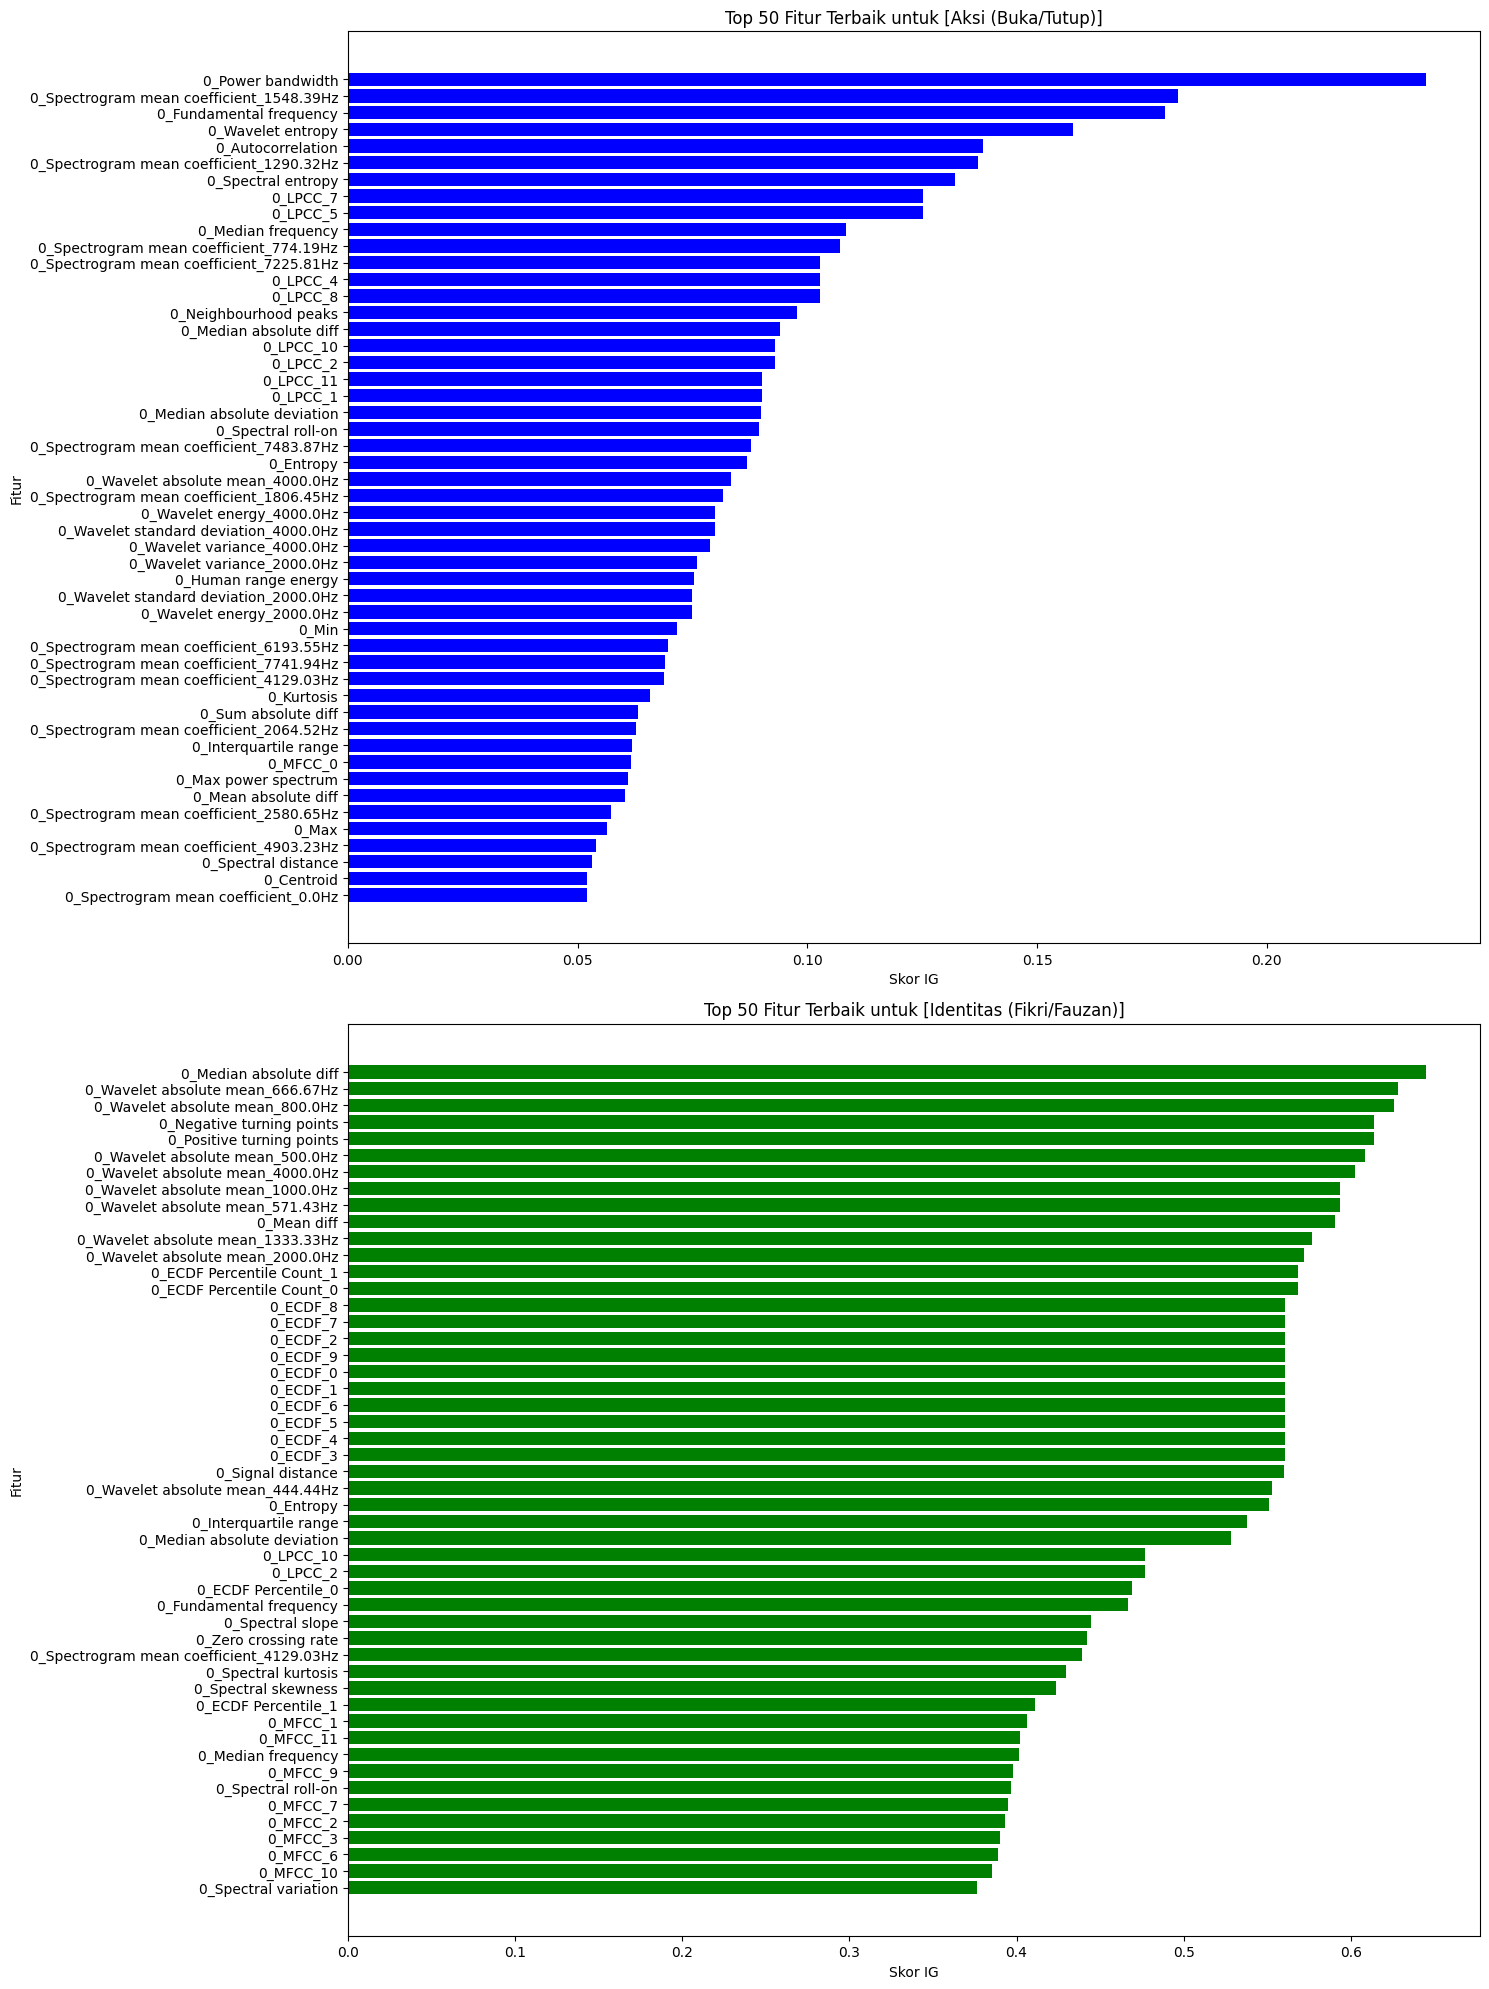

                         Feature   IG_Aksi  IG_Identitas
0              0_Absolute energy  0.000000      0.032356
1         0_Area under the curve  0.000000      0.000000
2              0_Autocorrelation  0.138133      0.284563
3                0_Average power  0.000000      0.067492
4                     0_Centroid  0.052096      0.118608
..                           ...       ...           ...
151   0_Wavelet variance_500.0Hz  0.006643      0.077227
152  0_Wavelet variance_571.43Hz  0.000000      0.073451
153  0_Wavelet variance_666.67Hz  0.036390      0.166503
154   0_Wavelet variance_800.0Hz  0.001065      0.188218
155         0_Zero crossing rate  0.047392      0.442221

[156 rows x 3 columns]


In [52]:
ig_scores_df = hitung_skor_ig_spesialis(X_clean, y_aksi_clean, y_identitas_clean)

# === SEL 3: Lihat Hasil ===
print(ig_scores_df)

### *Cek Fitur Domain*

In [53]:
def get_feature_domain(feature_name):
    # Hapus prefix '0_' untuk memudahkan pencocokan
    name = feature_name.replace('0_', '')

    # --- Domain SPECTRAL ---
    spectral_keywords = [
        'Spectral', 'Spectrogram', 'Wavelet', 'Fundamental frequency',
        'Human range energy', 'LPCC', 'MFCC', 'Max power spectrum',
        'Maximum frequency', 'Median frequency', 'Power bandwidth',
        'Average power'
    ]
    if any(keyword in name for keyword in spectral_keywords):
        return 'Spectral'

    # --- Domain TEMPORAL ---
    temporal_keywords = [
        'Absolute energy', 'Area under the curve', 'Autocorrelation', 'Centroid',
        'Mean absolute diff', 'Mean diff', 'Median absolute diff', 'Median diff',
        'Negative turning points', 'Neighbourhood peaks', 'Peak to peak distance',
        'Positive turning points', 'Signal distance', 'Slope', 'Sum absolute diff',
        'Zero crossing rate'
    ]
    if any(keyword in name for keyword in temporal_keywords):
        return 'Temporal'

    # --- Domain STATISTICAL ---
    # Jika bukan Spectral atau Temporal, kemungkinan besar Statistical
    statistical_keywords = [
        'ECDF', 'Entropy', 'Histogram', 'Interquartile range', 'Kurtosis',
        'Max', 'Min', 'Mean', 'Median', 'Root mean square', 'Skewness',
        'Standard deviation', 'Variance'
    ]
    if any(keyword in name for keyword in statistical_keywords):
        return 'Statistical'

    # --- Lainnya (Label atau fitur tak dikenal) ---
    return 'Other'


all_features = features_df.columns.tolist()


feature_metadata = pd.DataFrame({
    'Fitur': all_features,
    'Domain': [get_feature_domain(col) for col in all_features]
})

print(feature_metadata)

def cek_domain(nama_fitur_dicari):
    """
    Fungsi untuk mencari domain dari sebuah fitur secara cepat.
    Cukup masukkan sebagian nama fitur.
    """
    hasil = feature_metadata[feature_metadata['Fitur'].str.contains(nama_fitur_dicari, case=False)]
    if hasil.empty:
        print(f"Tidak ditemukan fitur yang mengandung kata '{nama_fitur_dicari}'.")
    else:
        print(f"Hasil pencarian untuk '{nama_fitur_dicari}':")
        display(hasil)

                      Fitur    Domain
0         0_Absolute energy  Temporal
1    0_Area under the curve  Temporal
2         0_Autocorrelation  Temporal
3           0_Average power  Spectral
4                0_Centroid  Temporal
..                      ...       ...
156                filename     Other
157              label_buka     Other
158             label_tutup     Other
159             label_fikri     Other
160            label_fauzan     Other

[161 rows x 2 columns]


In [40]:
cek_domain('Zero crossing rate')

Hasil pencarian untuk 'Zero crossing rate':


,Fitur,Domain
155,0_Zero crossing rate,Temporal


In [ ]:
def evaluate_n_features(
    X_imputed, 
    y_target, 
    ig_scores, 
    model_to_test, 
    step=1
):
    """
    Mengadaptasi 'evaluate_feature_reduction' untuk menguji satu target spesialis.
    
    Args:
        X_imputed (DataFrame): DataFrame fitur yang sudah di-imputasi (misal: 156 fitur).
        y_target (Series): Target Series spesialis (misal: y_aksi).
        ig_scores (Series): Series skor IG yang sesuai (misal: ig_scores_df['IG_Aksi']).
        model_to_test (estimator): Model scikit-learn (misal: RandomForestClassifier()).
        step (int): Kelipatan jumlah fitur yang akan diuji.
    """
    
    print(f"\n🚀 Mengevaluasi fitur untuk target: [{y_target.name}]")
    
    # 1. Urutkan fitur berdasarkan skor IG, buang yang skornya 0
    ig_series = pd.Series(ig_scores.values, index=X_imputed.columns)
    sorted_features = ig_series.sort_values(ascending=False)
    sorted_features = sorted_features[sorted_features > 0]
    
    print(f"Total fitur aktif (IG > 0): {len(sorted_features)}")
    
    results = []

    # 2. Looping dari semua fitur aktif hingga 1
    feature_counts = list(range(len(sorted_features), 0, -step))
    if 1 not in feature_counts:
        feature_counts.append(1) # Pastikan kita selalu menguji 1 fitur

    for n_features in tqdm(feature_counts, desc=f"Menguji {y_target.name}"):
        
        # Ambil N nama fitur teratas
        top_features_names = sorted_features.head(n_features).index.tolist()
        
        # Ambil subset X
        X_subset = X_imputed[top_features_names]

        # 3. Split data (PENTING: Split dulu sebelum scaling)
        X_train, X_test, y_train, y_test = train_test_split(
            X_subset, y_target, test_size=0.2, random_state=42, stratify=y_target
        )
        
        # 4. Normalisasi (PENTING: Fit hanya pada train, transform di test)
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # 5. Latih model
        # Kita clone agar model selalu baru di setiap iterasi
        model = clone(model_to_test) 
        model.fit(X_train_scaled, y_train)
        
        acc = model.score(X_test_scaled, y_test)
        
        results.append({
            "Jumlah_Fitur": n_features,
            "Akurasi": acc
        })

    # 6. Simpan hasil ke DataFrame
    results_df = pd.DataFrame(results).sort_values(by="Jumlah_Fitur")
    print(f"✅ Evaluasi untuk [{y_target.name}] selesai.")
    return results_df

In [54]:
imputer = SimpleImputer(strategy='median')
X_imputed_data = imputer.fit_transform(X_clean)
X_imputed_df = pd.DataFrame(X_imputed_data, columns=X_clean.columns)

# 2. Tentukan model yang ingin diuji
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# ==========================================================
# EVALUASI MODEL AKSI (BUKA/TUTUP)
# ==========================================================
results_aksi = evaluate_n_features(
    X_imputed=X_imputed_df,
    y_target=y_aksi_clean,
    ig_scores=ig_scores_df['IG_Aksi'],
    model_to_test=model_rf,
    step=1  # Uji setiap 5 fitur
)

# ==========================================================
# EVALUASI MODEL IDENTITAS (FIKRI/FAUZAN)
# ==========================================================
results_identitas = evaluate_n_features(
    X_imputed=X_imputed_df,
    y_target=y_identitas_clean,
    ig_scores=ig_scores_df['IG_Identitas'],
    model_to_test=model_rf,
    step=1  # Uji setiap 5 fitur
)


🚀 Mengevaluasi fitur untuk target: [Aksi (Buka/Tutup)]
Total fitur aktif (IG > 0): 112


Menguji Aksi (Buka/Tutup):   0%|          | 0/112 [00:00<?, ?it/s]

✅ Evaluasi untuk [Aksi (Buka/Tutup)] selesai.

🚀 Mengevaluasi fitur untuk target: [Identitas (Fikri/Fauzan)]
Total fitur aktif (IG > 0): 151


Menguji Identitas (Fikri/Fauzan):   0%|          | 0/151 [00:00<?, ?it/s]

✅ Evaluasi untuk [Identitas (Fikri/Fauzan)] selesai.


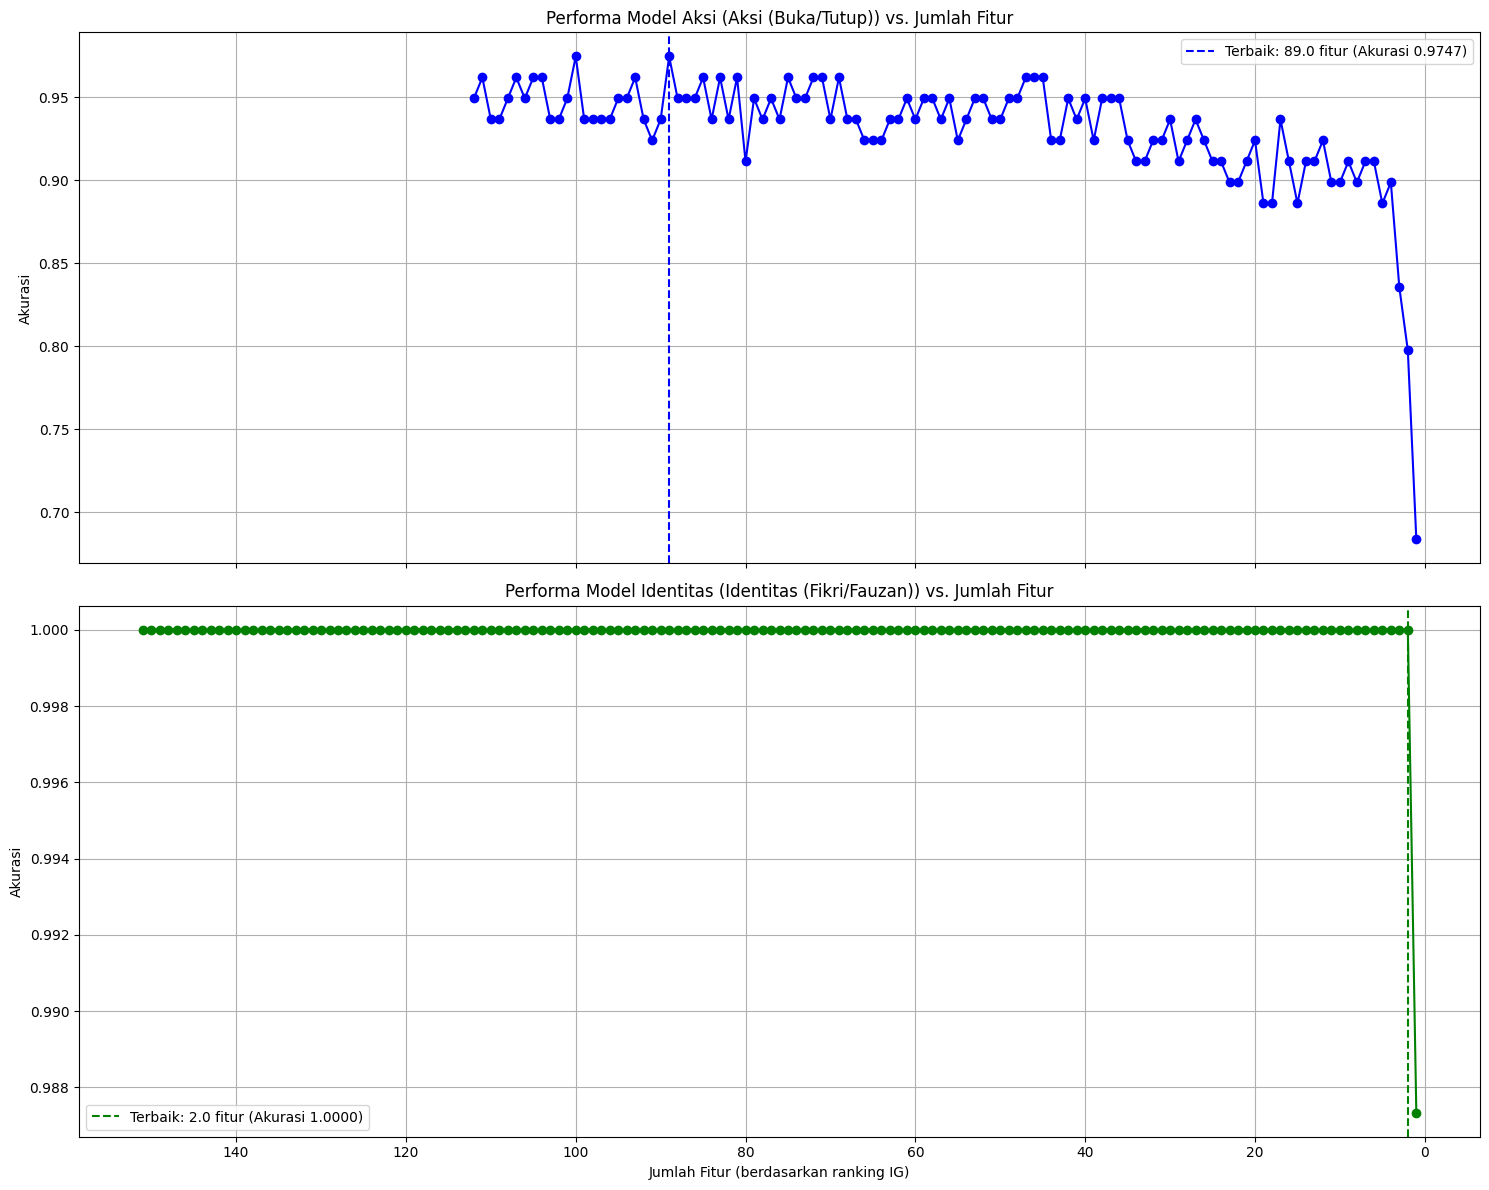


--- Hasil Optimal ---
Model Aksi: 89.0 fitur | Akurasi: 0.9747
Model Identitas: 2.0 fitur | Akurasi: 1.0000


In [55]:
# ==========================================================
# PLOT HASIL PERBANDINGAN
# ==========================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot Aksi
ax1.plot(results_aksi["Jumlah_Fitur"], results_aksi["Akurasi"], marker='o', color='blue')
ax1.set_title(f"Performa Model Aksi ({y_aksi.name}) vs. Jumlah Fitur")
ax1.set_ylabel("Akurasi")
ax1.grid(True)
# Tandai akurasi tertinggi
best_aksi = results_aksi.loc[results_aksi['Akurasi'].idxmax()]
ax1.axvline(x=best_aksi['Jumlah_Fitur'], color='blue', linestyle='--', 
            label=f"Terbaik: {best_aksi['Jumlah_Fitur']} fitur (Akurasi {best_aksi['Akurasi']:.4f})")
ax1.legend()

# Plot Identitas
ax2.plot(results_identitas["Jumlah_Fitur"], results_identitas["Akurasi"], marker='o', color='green')
ax2.set_title(f"Performa Model Identitas ({y_identitas.name}) vs. Jumlah Fitur")
ax2.set_xlabel("Jumlah Fitur (berdasarkan ranking IG)")
ax2.set_ylabel("Akurasi")
ax2.grid(True)
# Tandai akurasi tertinggi
best_identitas = results_identitas.loc[results_identitas['Akurasi'].idxmax()]
ax2.axvline(x=best_identitas['Jumlah_Fitur'], color='green', linestyle='--', 
            label=f"Terbaik: {best_identitas['Jumlah_Fitur']} fitur (Akurasi {best_identitas['Akurasi']:.4f})")
ax2.legend()

plt.gca().invert_xaxis() # Balik sumbu X agar dari banyak ke sedikit
plt.tight_layout()
plt.show()

print("\n--- Hasil Optimal ---")
print(f"Model Aksi: {best_aksi['Jumlah_Fitur']} fitur | Akurasi: {best_aksi['Akurasi']:.4f}")
print(f"Model Identitas: {best_identitas['Jumlah_Fitur']} fitur | Akurasi: {best_identitas['Akurasi']:.4f}")

### *Memilih Top Fitur*

In [58]:
def pilih_top_n_fitur(ig_scores_df, target_column_name, n_features):
    """
    FUNGSI 1: Memilih N nama fitur teratas berdasarkan skor IG.
    
    Args:
        ig_scores_df (DataFrame): DataFrame skor (dari hitung_skor_ig_spesialis).
        target_column_name (str): Nama kolom skor (misal: "IG_Aksi").
        n_features (int): Jumlah fitur yang ingin dipilih (misal: 110).
        
    Returns:
        top_features_list (list): Daftar berisi N nama fitur teratas.
    """
    print(f"\n[Fungsi 1] Memilih {n_features} fitur teratas untuk {target_column_name}...")
    
    # 1. Urutkan DataFrame berdasarkan skor target
    sorted_df = ig_scores_df.sort_values(by=target_column_name, ascending=False)
    
    # 2. Ambil 'N' nama fitur teratas dari kolom 'Feature'
    top_features_list = sorted_df['Feature'].head(n_features).tolist()
    
    print("✅ Pemilihan fitur teratas selesai.")
    return top_features_list

In [60]:
N_AKSI_OPTIMAL = 89

top_features_aksi = pilih_top_n_fitur(
    ig_scores_df, 'IG_Aksi', N_AKSI_OPTIMAL
)

X_aksi_final = X_clean[top_features_aksi]



[Fungsi 1] Memilih 89 fitur teratas untuk IG_Aksi...
✅ Pemilihan fitur teratas selesai.


In [73]:
N_IDENTITAS_OPTIMAL = 2

top_features_identitas = pilih_top_n_fitur(
    ig_scores_df, 'IG_Identitas', N_IDENTITAS_OPTIMAL
)

X_identitas_final = X_clean[top_features_identitas]



[Fungsi 1] Memilih 2 fitur teratas untuk IG_Identitas...
✅ Pemilihan fitur teratas selesai.


### *Melakukan PCA Terhadap Semua Fitur dan Jumlah Optimal Fitur*

In [63]:
def normalisasi_data_final(X_filtered):
    """
    FUNGSI 2: Menormalisasi data dan menyimpan scaler.
    
    Args:
        X_filtered (DataFrame): DataFrame yang HANYA berisi fitur terpilih.
        
    Returns:
        X_scaled (DataFrame): DataFrame yang sudah dinormalisasi.
        scaler (MinMaxScaler): Objek scaler yang sudah di-fit (untuk disimpan).
    """
    print("[Fungsi 2] Melakukan normalisasi (MinMaxScaler)...")
    
    # 1. Inisialisasi dan latih (fit) scaler PADA SELURUH data
    scaler = MinMaxScaler()
    X_scaled_data = scaler.fit_transform(X_filtered)
    
    # 2. Kembalikan sebagai DataFrame
    X_scaled = pd.DataFrame(
        X_scaled_data, 
        columns=X_filtered.columns, 
        index=X_filtered.index
    )
    
    print("✅ Normalisasi selesai.")
    return X_scaled, scaler

In [64]:
X_scaled_aksi, scaler_aksi = normalisasi_data_final(X_aksi_final)

[Fungsi 2] Melakukan normalisasi (MinMaxScaler)...
✅ Normalisasi selesai.


In [74]:
X_scaled_identitas, scaler_identitas = normalisasi_data_final(X_identitas_final)

[Fungsi 2] Melakukan normalisasi (MinMaxScaler)...
✅ Normalisasi selesai.


## **Melakukan PCA terhadap Semua Fitur dan Jumlah Optimal Fitur**

In [61]:
def latih_model_final(X_scaled, y_target):
    """
    FUNGSI 3: Melatih model Random Forest final pada seluruh data.
    
    Args:
        X_scaled (DataFrame): DataFrame yang sudah dinormalisasi.
        y_target (Series): Target Series yang sesuai.
        
    Returns:
        model (RandomForestClassifier): Model yang sudah di-fit (untuk disimpan).
    """
    print(f"[Fungsi 3] Melatih model final untuk target '{y_target.name}'...")
    
    # Latih model final pada SELURUH data
    model = RandomForestClassifier(random_state=42, n_jobs=-1)
    model.fit(X_scaled, y_target)
    
    print("✅ Pelatihan model final selesai.")
    return model

In [65]:
model_aksi = latih_model_final(X_scaled_aksi, y_aksi_clean)

[Fungsi 3] Melatih model final untuk target 'Aksi (Buka/Tutup)'...
✅ Pelatihan model final selesai.


In [75]:
model_identitas = latih_model_final(X_scaled_identitas, y_identitas_clean)

[Fungsi 3] Melatih model final untuk target 'Identitas (Fikri/Fauzan)'...
✅ Pelatihan model final selesai.


### *Melakukan PCA Terhadap Semua Fitur dan Jumlah Optimal Fitur*

In [77]:
def evaluasi_model_final(
    X_data_clean, 
    y_data_clean, 
    top_features_list,
    label_names_dict
):
    """
    Melakukan evaluasi formal (Train/Test Split) untuk satu model spesialis
    dan menampilkan laporan lengkap (Akurasi, Confusion Matrix, Classification Report).
    
    Args:
        X_data_clean (DataFrame): DataFrame fitur bersih (misal: X_clean).
        y_data_clean (Series): Target Series bersih (misal: y_aksi_clean).
        top_features_list (list): Daftar nama fitur optimal (misal: top_features_aksi).
        label_names_dict (dict): Kamus untuk nama label (misal: {1: "Buka", 0: "Tutup"}).
    """
    
    print(f"\n===== MEMULAI EVALUASI FORMAL UNTUK: [{y_data_clean.name}] =====")
    
    # 1. Filter X_clean HANYA ke fitur optimal
    X_filtered = X_data_clean[top_features_list]
    
    # 2. Lakukan Train/Test Split (80% Latih, 20% Uji)
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_data_clean, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_data_clean
    )
    print(f"Data di-split: {len(y_train)} Latih, {len(y_test)} Uji")

    # 3. Normalisasi (PENTING: Fit HANYA pada train)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Normalisasi (MinMax) selesai.")

    # 4. Latih Model (HANYA pada train)
    model = RandomForestClassifier(random_state=42, n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    print("Model (RandomForest) selesai dilatih.")

    # 5. Prediksi pada data Uji
    y_pred = model.predict(X_test_scaled)

    # 6. Tampilkan Laporan Hasil
    print("\n--- HASIL EVALUASI (PADA DATA UJI 20%) ---")
    
    # Akurasi
    acc = accuracy_score(y_test, y_pred)
    print(f"\nAkurasi: {acc * 100:.2f}%")
    
    # Label names untuk laporan
    target_names = [label_names_dict[key] for key in sorted(label_names_dict.keys())]
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=target_names, 
        yticklabels=target_names
    )
    plt.title(f"Confusion Matrix - {y_data_clean.name}")
    plt.ylabel("Label Aktual (True)")
    plt.xlabel("Label Prediksi (Predicted)")
    plt.show()


===== MEMULAI EVALUASI FORMAL UNTUK: [Aksi (Buka/Tutup)] =====
Data di-split: 313 Latih, 79 Uji
Normalisasi (MinMax) selesai.
Model (RandomForest) selesai dilatih.

--- HASIL EVALUASI (PADA DATA UJI 20%) ---

Akurasi: 97.47%

Classification Report:
              precision    recall  f1-score   support

       Tutup       0.95      1.00      0.98        40
        Buka       1.00      0.95      0.97        39

    accuracy                           0.97        79
   macro avg       0.98      0.97      0.97        79
weighted avg       0.98      0.97      0.97        79


Confusion Matrix:


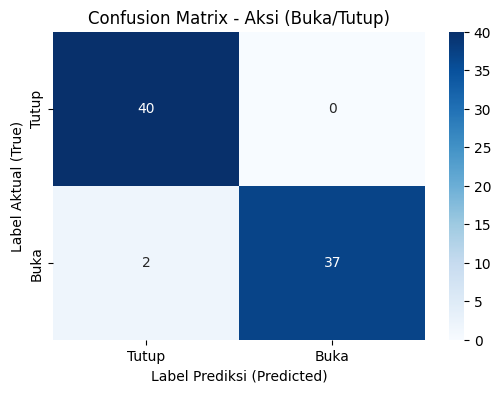

In [78]:
evaluasi_model_final(
    X_data_clean=X_clean,
    y_data_clean=y_aksi_clean,
    top_features_list=top_features_aksi,
    label_names_dict={1: "Buka", 0: "Tutup"} # (PENTING: 1=Buka, 0=Tutup)
)


===== MEMULAI EVALUASI FORMAL UNTUK: [Identitas (Fikri/Fauzan)] =====
Data di-split: 313 Latih, 79 Uji
Normalisasi (MinMax) selesai.
Model (RandomForest) selesai dilatih.

--- HASIL EVALUASI (PADA DATA UJI 20%) ---

Akurasi: 100.00%

Classification Report:
              precision    recall  f1-score   support

      Fauzan       1.00      1.00      1.00        39
       Fikri       1.00      1.00      1.00        40

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79


Confusion Matrix:


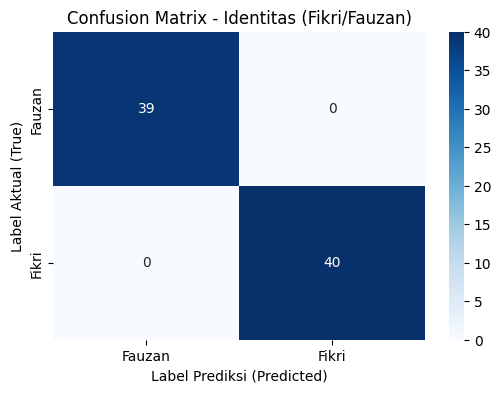

In [79]:
evaluasi_model_final(
    X_data_clean=X_clean,
    y_data_clean=y_identitas_clean,
    top_features_list=top_features_identitas,
    label_names_dict={1: "Fikri", 0: "Fauzan"} # (PENTING: 1=Fikri, 0=Fauzan)
)

## **Visualisasi Perbandingan PCA Full Fitur dan Jumlah Optimal Fitur**

In [98]:
def predict_new_audio_spesialis(
    filepath,
    model_aksi, selected_features_aksi, scaler_aksi, labels_aksi,
    model_identitas, selected_features_identitas, scaler_identitas, labels_identitas,
    target_sr=16000 # Harus sama dengan SR training
):
    """
    Versi baru dari fungsi prediksi yang menjalankan DUA model spesialis
    (Aksi dan Identitas) pada satu file audio.
    """
    
    print(f"\n===== 🚀 Menguji File Baru: {filepath} =====")

    # 1. Convert ke WAV + samakan SR
    try:
        signal, sr = librosa.load(filepath, sr=target_sr, mono=True)
        temp_out = "temp_converted_test.wav"
        sf.write(temp_out, signal, target_sr)
    except Exception as e:
        print(f"❌ Error saat me-load audio: {e}")
        return

    print(f"Audio dikonversi | SR = {sr}, Durasi = {len(signal)/sr:.2f} detik")

    # 2. Masukkan ke TSFEL
    # (Menggunakan format data_list yang diharapkan oleh extract_features_tsfel)
    data_list = [{
        'filename': filepath,
        'audio_signal': signal,
        'sampling_rate': sr,
        'label_buka': 0, 'label_tutup': 0, 
        'label_fikri': 0, 'label_fauzan': 0
    }]

    # 3. Ekstrak Fitur (Hanya satu kali)
    # (features_df akan berisi SEMUA 156+ fitur)
    try:
        features_df = extract_features_tsfel(data_list)
        if features_df.empty:
            print("❌ Gagal mengekstrak fitur dari audio ini.")
            return
    except Exception as e:
        print(f"❌ Error saat ekstraksi TSFEL: {e}")
        return

    # 4. Hapus file temp
    if os.path.exists(temp_out):
        os.remove(temp_out)
        
    print("\n--- Pipeline Prediksi Dimulai ---")

    try:
        # 5. PIPELINE A: Model Aksi (Buka/Tutup)
        # 5a. Seleksi fitur Aksi
        selected_df_aksi = features_df[selected_features_aksi]
        # 5b. Normalisasi (MinMax) Aksi
        scaled_aksi = scaler_aksi.transform(selected_df_aksi)
        # 5c. Prediksi Aksi
        pred_idx_aksi = model_aksi.predict(scaled_aksi)[0]
        hasil_aksi = labels_aksi[pred_idx_aksi] # Terjemahkan (misal: 1 -> "Buka")

        # 6. PIPELINE B: Model Identitas (Fikri/Fauzan)
        # 6a. Seleksi fitur Identitas
        selected_df_identitas = features_df[selected_features_identitas]
        # 6b. Normalisasi (MinMax) Identitas
        scaled_identitas = scaler_identitas.transform(selected_df_identitas)
        # 6c. Prediksi Identitas
        pred_idx_identitas = model_identitas.predict(scaled_identitas)[0]
        hasil_identitas = labels_identitas[pred_idx_identitas] # Terjemahkan

        # 7. Tampilkan Hasil Gabungan
        print("\n✅ Prediksi Selesai!")
        print("---------------------------------")
        print(f"   👤 Prediksi Identitas: {hasil_identitas}")
        print(f"   📢 Prediksi Perintah : {hasil_aksi}")
        print("---------------------------------")

    except KeyError as e:
        print(f"\n❌ ERROR: Terjadi KeyError saat seleksi fitur: {e}")
        print("   Pastikan daftar 'selected_features' Anda sudah benar.")
    except Exception as e:
        print(f"\n❌ ERROR saat prediksi: {e}")

In [99]:
# 1. Tentukan file yang ingin Anda uji
# (Bisa .aac, .mp3, .wav, dll.)
file_untuk_dites = "dataset/20251115_125523.aac"

# 2. Panggil fungsi prediksi baru
# Kita masukkan semua komponen yang sudah dilatih (dari memori)
try:
    predict_new_audio_spesialis(
        filepath=file_untuk_dites,
        
        # Komponen Model Aksi
        model_aksi=model_aksi, 
        selected_features_aksi=top_features_aksi, 
        scaler_aksi=scaler_aksi,
        labels_aksi={1: "Buka", 0: "Tutup"},
        
        # Komponen Model Identitas
        model_identitas=model_identitas, 
        selected_features_identitas=top_features_identitas, 
        scaler_identitas=scaler_identitas,
        labels_identitas={1: "Fikri", 0: "Fauzan"}
    )

except NameError as e:
    print(f"❌ ERROR: Variabel tidak ditemukan: {e}")
    print("Pastikan Anda sudah menjalankan skrip pelatihan final")
    print("dan memiliki variabel seperti 'model_aksi', 'scaler_aksi', dll.")
except Exception as e:
    print(f"❌ Terjadi error tak terduga: {e}")


===== 🚀 Menguji File Baru: dataset/20251115_125523.aac =====
Audio dikonversi | SR = 16000, Durasi = 2.02 detik
🚀 Memulai proses ekstraksi fitur menggunakan TSFEL...



C:\Users\MyBook Z Series\AppData\Local\Temp\ipykernel_4700\2645817866.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(filepath, sr=target_sr, mono=True)
d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\venv_py\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



🎉 Ekstraksi fitur selesai!
📊 Total data fitur: 1 baris, 161 kolom

--- Pipeline Prediksi Dimulai ---

✅ Prediksi Selesai!
---------------------------------
   👤 Prediksi Identitas: Fauzan
   📢 Prediksi Perintah : Tutup
---------------------------------


d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\venv_py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\venv_py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### *Simpan Model*

In [93]:
package_aksi = {
    "model": model_aksi,
    "scaler": scaler_aksi,
    "selected_features": top_features_aksi,
    "labels": {1: "Buka", 0: "Tutup"} # Label sesuai y_aksi (1=buka)
}
joblib.dump(package_aksi, "saved_models/audio-multilabel(1)/model_aksi_final.pkl")
print("✅ Model Aksi final berhasil disimpan.")

✅ Model Aksi final berhasil disimpan.


In [95]:
package_identitas = {
    "model": model_identitas,
    "scaler": scaler_identitas,
    "selected_features": top_features_identitas,
    "labels": {1: "Fikri", 0: "Fauzan"} # Label sesuai y_identitas (1=fikri)
}
joblib.dump(package_identitas, "saved_models/audio-multilabel(1)/model_identitas_final.pkl")
print("✅ Model Identitas final berhasil disimpan.")

✅ Model Identitas final berhasil disimpan.
